In [1]:
import numpy as np
import pandas as pd
import scipy.stats
import math

# System files 
import sys
import os

#sys.path.append('..')  # now I'm in the parent directory
cwd = os.getcwd()
print(cwd)

# external libraries
from src.cleaning.export_data import *
from src.functions.sectors import *
from src.cleaning.processing import *
from src.visualizing.complex_eigenvectors import *
from src.hpca.hilbert import *
from src.hpca.hpca import *

# Plotting
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns 
%matplotlib inline

# Set the preset style and context
sns.set_style('ticks')
sns.set_palette('dark')

rcParams['axes.spines.bottom']=True
rcParams['axes.spines.right']=False
rcParams['axes.spines.left']=False
rcParams['axes.spines.top']=False
rcParams['axes.linewidth'] = 2
rcParams['axes.edgecolor'] = 'grey'

rcParams['axes.ymargin'] = 0
rcParams['axes.axisbelow'] = True
rcParams['axes.labelsize'] = 14
rcParams['legend.fontsize'] = 15
rcParams['legend.loc'] = 'upper right' 

rcParams['ytick.major.width'] = 0
rcParams['ytick.major.size'] = 0
rcParams['ytick.color'] = 'grey'

rcParams['xtick.major.width'] = 2
rcParams['xtick.major.size'] = 5
rcParams['xtick.color'] = 'grey'

rcParams['font.size'] = 14
rcParams['font.family'] = 'Arial'
#rcParams['text.color'] = 'grey'
#rcParams['axes.labelcolor'] = 'grey'

rcParams['figure.figsize'] = (10, 10)

rcParams['savefig.bbox'] = 'tight'
rcParams['savefig.dpi'] = 900
rcParams['savefig.transparent'] = True

# Plot Styles
rcParams['lines.linewidth'] = 1
rcParams['lines.markersize'] = 4

/Users/pietrobicocchi/Desktop/hilbert_pca_svd


- clean sales and prices

In [2]:
path_clean_s = os.getcwd() + '/data/cleaned/CompuStat_sales.pkl'
path_clean_p = os.getcwd() + '/data/cleaned/CompuStat_prices.pkl'

# Load the saved DataFrame for RETURNS of Sales and Prices 
sales = pd.DataFrame(load_cleaned_data(path_clean_s)) 
prices = pd.DataFrame(load_cleaned_data(path_clean_p))

- sectorizing the sales and the prices

In [3]:
gvkeys = list(sales.columns)  # list of gvkeys of my sales data
sectors = extract_data(cwd + '/data/raw/CompuStat/sectors.csv') 
key_to_sect = get_unique_sectors(sectors)
key_sect = gvkeys_to_sect(gvkeys, key_to_sect)
idx_by_sector, sector_dict, sector_indices, sector_labels = create_sectors(key_sect)

/Users/pietrobicocchi/Desktop/hilbert_pca_svd/src/functions/sectors.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sectors["datadate"] = pd.to_datetime(sectors["datadate"])
/Users/pietrobicocchi/Desktop/hilbert_pca_svd/src/functions/sectors.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sectors['gsector'] = sectors['gsector'].fillna(1)
/Users/pietrobicocchi/Desktop/hilbert_pca_svd/src/functions/sectors.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

- creating 'ad hoc' tailored prices: in order to have match sales and prices data for the same companies.

In [4]:
sales_df, prices_df = raw_to_dataframes(extract_data(os.getcwd() + '/data/raw/CompuStat/crsp_ccm_inventories_sales.csv'))
sales_keys = sales.keys()
tailored_prices = tailored_clean(prices_df, sales_keys)
prices = tailored_prices # the prices we are interested in

/Users/pietrobicocchi/opt/anaconda3/lib/python3.9/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


From now on we will work with:
- Sales (log-returns normalized)
- Prices (log-returns normalized)
for **787 companies** in a time period of **248 quarters** = 62 years

In [5]:
sales.head(10)

GVKEY,1004,1045,1062,1072,1075,1076,1078,1104,1121,1161,...,11669,11670,11672,11687,13003,13714,14253,15106,15247,28590
datadate,,,,,,,,,,,,,,,,,,,,,
1961-06-30,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
1961-09-30,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
1961-12-31,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
1962-03-31,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
1962-06-30,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
1962-09-30,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.287553,0.0,0.000000
1962-12-31,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,-0.211060,0.0,0.000000
1963-03-31,0.0,0.0,0.0,0.0,-0.155711,0.0,1.415907,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.510730,0.0,0.002523
1963-06-30,0.0,0.0,0.0,0.0,-0.088812,0.0,1.931288,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,-2.349871,0.0,-0.025226


In [6]:
prices.head(10)

GVKEY,1004,1045,1062,1072,1075,1076,1078,1104,1121,1161,...,11669,11670,11672,11687,13003,13714,14253,15106,15247,28590
datadate,,,,,,,,,,,,,,,,,,,,,
1961-06-30,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1961-09-30,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1961-12-31,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1962-03-31,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1962-06-30,0.0,0.0,0.0,0.0,-3.091180,0.0,-1.175047,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,-3.140166,0.0,0.0
1962-09-30,0.0,0.0,0.0,0.0,0.709329,0.0,-0.287283,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.976992,0.0,0.0
1962-12-31,0.0,0.0,0.0,0.0,0.690092,0.0,1.363055,0.0,0.0,0.0,...,0.073211,0.0,0.0,0.0,0.0,0.0,0.0,0.883223,0.0,0.0
1963-03-31,0.0,0.0,0.0,0.0,-0.099118,0.0,0.844746,0.0,0.0,0.0,...,0.219140,0.0,0.0,0.0,0.0,0.0,0.0,-0.868704,0.0,0.0
1963-06-30,0.0,0.0,0.0,0.0,-0.064515,0.0,0.321809,0.0,0.0,0.0,...,0.038327,0.0,0.0,0.0,0.0,0.0,0.0,-0.382195,0.0,0.0


### Hilbert PCA

- analytic signal for the returns
    
<math>\begin{align}
s_\mathrm{a}(t) &= s(t) + j\hat{s}(t)
\end{align}</math>

where $\hat{s}(t)$ is the hilbert transform of the returns

- example 1

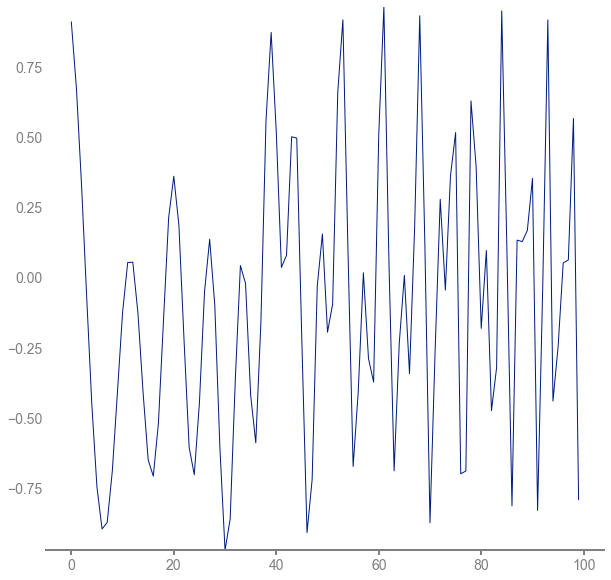

In [7]:
x = np.linspace(0,10, 100)
series1 = np.cos(x**2)*np.sin(4*x + 2)
series2 = np.sin(x**2)*np.cos(4*x**2 + 4)
an_series = np.column_stack((series1, series2))

plt.plot(series1)

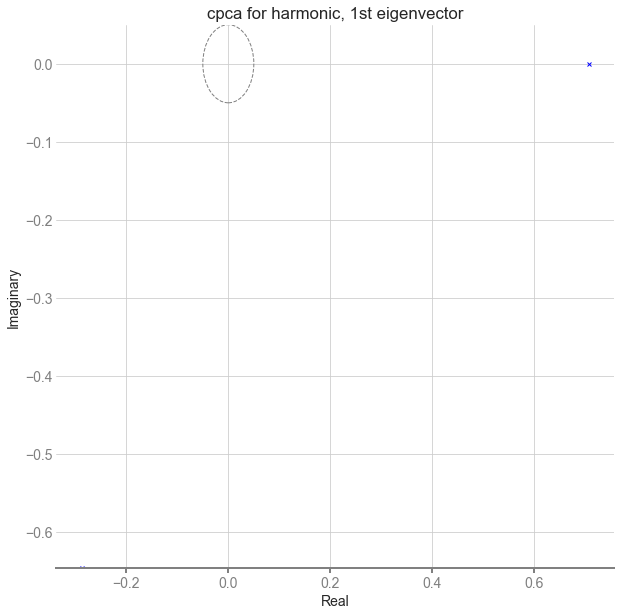

In [8]:
analytic = analytic_signal(an_series)
corr, eVal, eVec = complex_eigendecomposition(analytic)
plotting_complex_plane(eVec[:,0], title = "cpca for harmonic, 1st eigenvector")

- Example 2

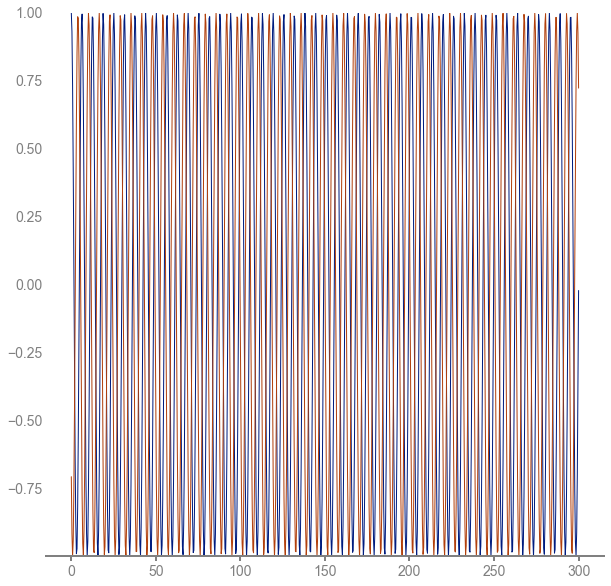

            0         1
0    1.000000 -0.707107
1    0.930336 -0.917149
2    0.731049 -0.999406
3    0.429906 -0.942417
4    0.068864 -0.754123
..        ...       ...
795 -0.998904  0.739427
796 -0.912153  0.934797
797 -0.698312  0.999924
798 -0.387177  0.925732
799 -0.022097  0.722559

[800 rows x 2 columns]


In [9]:
x = np.linspace(0,300, num = 800)
θ = np.pi*(3/4)
series1 = np.cos(x)
series2 = np.cos(x + θ)
an_series = np.column_stack((series1, series2))

plt.plot(x, series1)
plt.plot(x, series2)
plt.show()
print(pd.DataFrame(an_series))

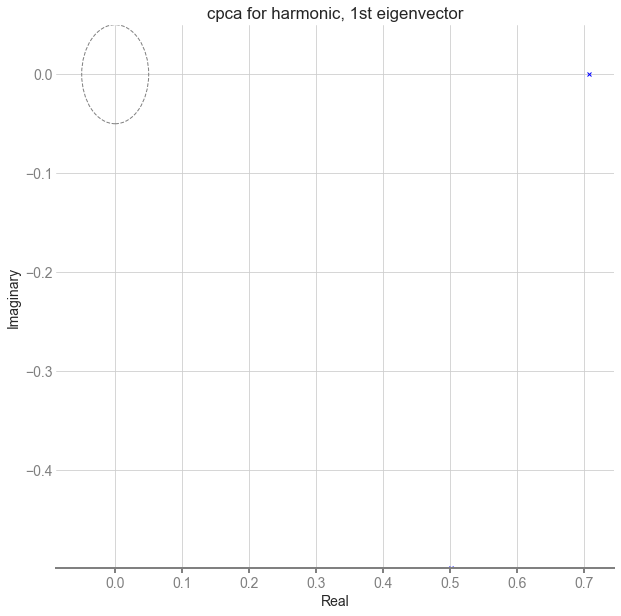

In [10]:
analytic = analytic_signal(an_series)
corr, eVal, eVec = complex_eigendecomposition(analytic)
plotting_complex_plane(eVec[:,0], title = "cpca for harmonic, 1st eigenvector")

- CPCA on Sales

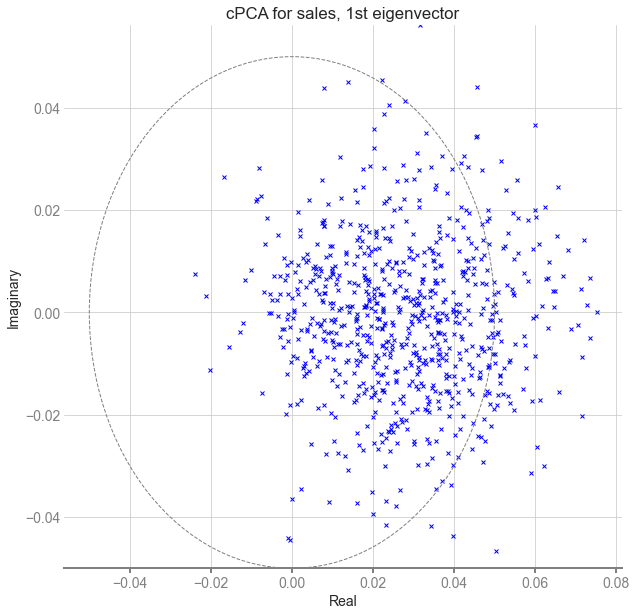

In [11]:
analytic_s = analytic_signal(sales)
corr, eVal, eVec = complex_eigendecomposition(analytic_s)
plotting_complex_plane(eVec[:,0], title = "cPCA for sales, 1st eigenvector")

- cPCA on Prices

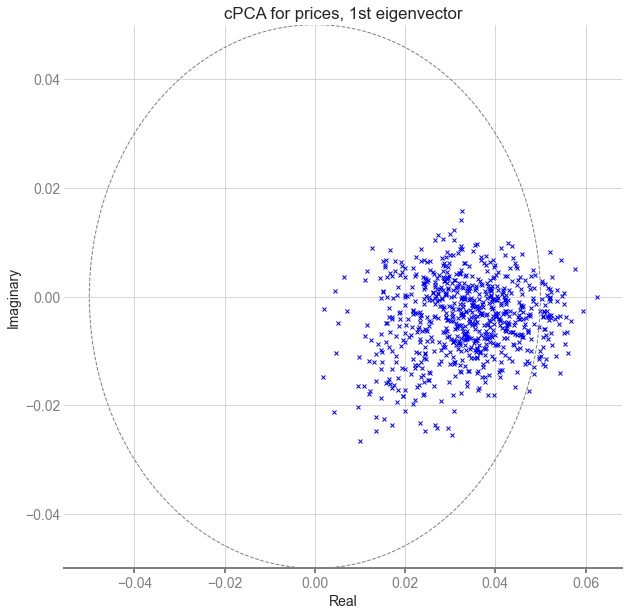

In [12]:
analytic_p = analytic_signal(prices)
corr, eVal, eVec = complex_eigendecomposition(analytic_p)
plotting_complex_plane(eVec[:,0], title = "cPCA for prices, 1st eigenvector")

- cSVD (complex SVD), **prices** leading and **sales** lagging

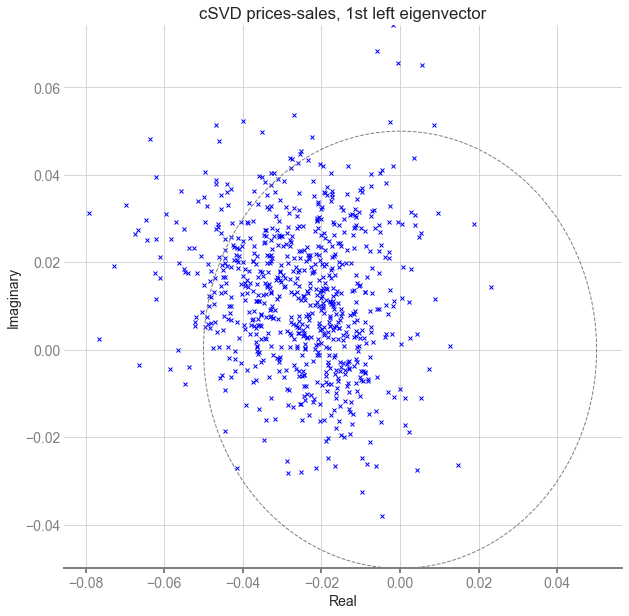

In [13]:
u, s, v = complex_svd(analytic_p, analytic_s)
plotting_complex_plane(u[:,0], title = "cSVD prices-sales, 1st left eigenvector")

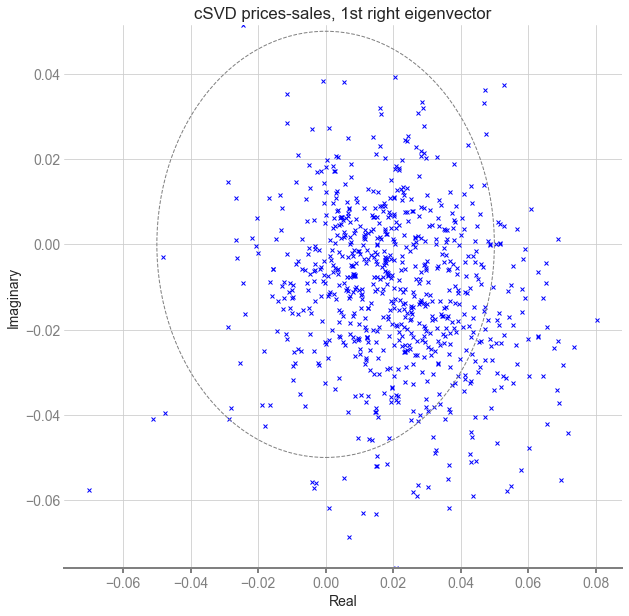

In [14]:
plotting_complex_plane(v.T[:,0], title = "cSVD prices-sales, 1st right eigenvector")